In [1]:
from __future__ import print_function
import os
import inspect

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('ticks')

%matplotlib inline

In [2]:
# Import pdNLS
try:
    # If pdNLS is in PYTHONPATH (or is installed), then use a direct import
    import pdNLS
    #from pdNLS import exponential_decay
    
except ImportError:
    # Attempt to demo pdNLS without installing by importing from directory
    pdNLS_path = '../../pdNLS'
    
    print("Module pdNLS was not found in PYTHONPATH. Looking for module in directory '{:s}'".format(pdNLS_path))
    
    if os.path.exists(pdNLS_path):
        import imp
        pdNLS = imp.load_package('pdNLS', pdNLS_path)
        #exponential_decay = imp.load_package('pdNLS.exponential_decay', pdNLS_path)
        print("Module pdNLS was found in the directory '{:s}' and imported.".format(pdNLS_path))
    else:
        raise ImportError("Module pdNLS could not be found in the directory '{:s}'.".format(pdNLS_path) + \
        "This demonstration will not run until the module is located.")

Module pdNLS was not found in PYTHONPATH. Looking for module in directory '../../pdNLS'
Module pdNLS was found in the directory '../../pdNLS' and imported.


## Overview

`pdNLS` is a library for performing non-linear least squares (NLS) minimization. It attempts to seamlessly incorporate this task in a Pandas-focused workflow. Input data are expected in dataframes, and multiple regressions can be performed using functionality similar to Pandas `groupby`. Results are returned as grouped dataframes and include best-fit parameters, statistics, residuals, and more. The results can be easily visualized using [`seaborn`](https://github.com/mwaskom/seaborn).

`pdNLS` is related to libraries such as [`statsmodels`](http://statsmodels.sourceforge.net) and [`scikit-learn`](http://scikit-learn.org/stable/) that provide linear regression functions that operate on dataframes. As I was unable to find any that perform non-linear regression, I developed `pdNLS` to fill this niche. 

`pdNLS` utilizes [`lmfit`](https://github.com/lmfit/lmfit-py), a flexible and powerful library for non-linear least squares minimization, which in turn, makes use of `scipy.optimize.leastsq`. I began using `lmfit` several years ago because I like the flexibility it offers for testing different modeling scenarios and the variety of assessment statistics it provides. However, I found myself writing many `for` loops to perform regressions on groups of data and aggregate the resulting output.

Some additional 'niceties' associated with the input of parameters and equations have also been incorporated. `pdNLS` also utilizes multithreading for the calculation of confidence intervals, as this process is time consuming when there are more than a few groups.

### Input data

This `pdNLS` demonstration utilizes nuclear magnetic resonance (NMR) data acquired at two different magnetic field strengths (14.1 and 21.1 T) on a protein called GCN4. For the purpose of this demonstration, analyzing this data requires determining the rate of exponential decay as a function of time for every amino acid residue at each of two magnetic field strengths. 

There are 12 amino acids in the enclosed data set, so using amino acid residue (`resi`) and magnetic field (`field`) as the `groupby` columns results in 24 minimization operations.

In [3]:
! head GCN4_twofield.csv

resi	field	time	intensity
51	14.1	0.004	1624.219428
51	14.1	0.008	1491.46728
51	14.1	0.024	1022.717456
51	14.1	0.064	448.038543
51	14.1	0.096	270.116745
51	14.1	0.144	148.671651
51	14.1	0.208	103.322608
52	14.1	0.004	1614.38584
52	14.1	0.008	1500.47205


In [4]:
data = pd.read_csv('GCN4_twofield.csv', sep='\t')

### Dataframe input

`pdNLS` uses a dataframe for input as well as a column (or list of columns, called `groupbycols` here) for the `groupby` operation prior to fitting. A string input corresponding to the independent data (`xname`) and dependent data (`yname`) are required. Errors for weighting during fitting (`yerr`, not used here) can also be used.

In [5]:
groupbycols = ['resi', 'field']
xname = 'time'
yname = 'intensity'
yerr = None

### Minimization equation

The function format required by `pdNLS` is similar that described in the [`lmfit` documentation](http://lmfit.github.io/lmfit-py/fitting.html#writing-a-fitting-function). Generally speaking, all fit parameters must appear first and they must be contained in a single variable or dictionary that is then unpacked inside the function. The independent (x-) data is next and then the dependent (y-) data.

`pdNLS` contains a separate function that calculates the regression error, so the input function need only calculate the expected value based on input parameters.

Common equations are provided in the `function` module. Currently, an exponential decay and a linear function are provided.

This demo will be using the exponential decay function, whose parameters are:  

$I_{(t)} = I_{(0)} \space e^{(-R * t)}$  

where $I_{(0)}$ is the initial intensity, $I_{(t)}$ is the intensity at time $t$, and $R$ is the exponential decay  rate. 

Here is what the exponential decay function looks like:  

In [6]:
exponential_decay = pdNLS.functions.exponential_decay
print(inspect.getsource(exponential_decay))

def exponential_decay(par, xdata):
    
    # Parse multiple input parameter
    # formats for intensity, rate    
    if hasattr(par,'valuesdict'):
        # lmfit parameter format
        var = par.valuesdict()
        inten = var['inten']
        rate = var['rate']
    elif hasattr(par,'keys'):
        # dict format
        inten = par['inten']
        rate = par['rate']
    else:
        # array/list/tuple format
        inten = par[0]
        rate = par[1]

    # Calculate the y-data from the parameters
    return inten * np.exp(-1*rate*xdata)



### Parameters

Parameters are usually input as a dictionary, although dataframe input will soon be an option. The list of parameters must be the same as the order in which they are unpacked by the minimization function. The keys for each parameter follows the format used by [`lmfit`](). 

Parameter starting values can be a single value or a list. If a single value is entered, it is used for each measurement. If a list or array is entered (see the intensity values below), it must be the same length as the number of groups.

In [7]:
params = [{'name':'inten', 
           'value':np.asarray(data.groupby(groupbycols)[yname].max()), 
           'vary':True},
          {'name':'rate', 
           'value':20.0, 
           'vary':True}]

### Other inputs

The confidence interval(s) (`sigma`) to be calculated can be entered as a single value or a list. The default is 95% (0.95). The number of threads (`threads`) to use for confidence interval calculation will be automatically calculated if not explicitly set.

The only minimization method (`method`) currently supported is Levenberg-Marquardt ('leastsq'). Other methods will be added in the future. 

In [8]:
sigma = 0.95
threads = None
method = 'leastsq'

## Regression and prediction

Performing the regression is quite simple--just call the class `pdNLS` with input parameters set and then use the `fit` method.

In [10]:
fit_data = pdNLS.pdNLS(data, exponential_decay, 
                       groupbycols, params, 
                       xname, yname, 
                       method=method, sigma=sigma,
                       threads=threads)
fit_data.fit()

A best-fit line can be calculated using the `predict` method.

*TODO: update when I fix the bug in the predict method*

In [11]:
# fit_data.predict()

## Results

`pdNLS` creates four output tables:

* **data** for the input data, calculated data, and residuals
* **results** that contains the best-fit parameters and estimation of their error
* **stats** for statistics related to the regression, such as chi-squared and AIC
* **model** that contains a best-fit line created by the `predict` method

Here is part of the **results** table for a single residue and magnetic field:

*TODO: the ycalc and residuals will be added when `predict` is fixed*

In [16]:
resi = 51
field = 21.1

fit_data.data.loc[(resi, field)]

time     intensity
resi field                     
51   21.1   0.004  58597.437500
     21.1   0.008  51579.929688
     21.1   0.024  33917.402344
     21.1   0.064  13755.859375
     21.1   0.096   7755.250000
     21.1   0.144   6441.057129
     21.1   0.208   3995.350098

The **results** table contains best-fit parameters, their standard errors, and confidence intervals.

In [17]:
fit_data.results.head(n=4)

inten                                 rate            \
                   value       stderr       ci0.95      value    stderr   
resi field                                                                
51   14.1    1714.801224    37.873598    58.412803  19.650244  1.017596   
     21.1   61172.422208  2056.605717  3233.839208  21.244426  1.632509   
52   14.1    1778.899941    17.866286    32.098115  23.354822  0.487731   
     21.1   72392.056557   511.164845   899.609872  32.172892  0.899967   

                      
              ci0.95  
resi field            
51   14.1   1.737309  
     21.1   2.747193  
52   14.1   0.961983  
     21.1   1.359184

The **stats** table contains statistics for each of the regressions:

* Number of observations (`nobs`)
* Number of fit parameters (`npar`)
* Degrees of freedom (`dof`)
* Chi-squared (`chisqr`)
* Reduced chi-squared (`redchi`)
* Akaike information criterion (`aic`)
* Bayesian information criterion (`bic`)
* Covariance matrix (`covar`)

In [18]:
fit_data.stats.head(n=4)

nobs  npar  dof        chisqr        redchi         aic  \
resi field                                                            
51   14.1      7     2    5  4.618933e+07  9.237866e+06  116.271750   
     21.1      7     2    5  3.867213e+14  7.734425e+13  227.855012   
52   14.1      7     2    5  2.013268e+06  4.026536e+05   94.340823   
     21.1      7     2    5  2.469331e+12  4.938662e+11  192.478713   

                   bic                                              covar  
resi field                                                                 
51   14.1   116.163570  [[1434.40941598, 25.1920994106], [25.192099410...  
     21.1   227.746832  [[4229627.07654, 2206.79019345], [2206.7901934...  
52   14.1    94.232643  [[319.204188624, 6.64745810301], [6.6474581030...  
     21.1   192.370534  [[261289.498533, 362.755226131], [362.75522613...

It is also easy to access a single covariance matrix for calculations.

In [19]:
fit_data.stats.covar.loc[(resi, field)]

array([[  4.22962708e+06,   2.20679019e+03],
       [  2.20679019e+03,   2.66508651e+00]])

## Visualization

The results are easy to visualize in facet plots with Seaborn. The facet plots will be easier to see if the intensities are normalized first.

In [20]:
fit_itensities = (fit_data.results
                  .loc[:,('inten','value')]
                  .to_frame()
                  )

fit_itensities.columns=['inten_fit']

In [21]:
fit_data.data = pd.merge(fit_data.data,
                         fit_itensities,
                         left_index=True,
                         right_index=True,
                         how='left'
                        )

fit_data.data['intensity'] /= fit_data.data.inten_fit
#fit_data.data['ycalc'] /= fit_data.data.inten_fit

*TODO: best-fit lines will be added when `predict` method is fixed.*

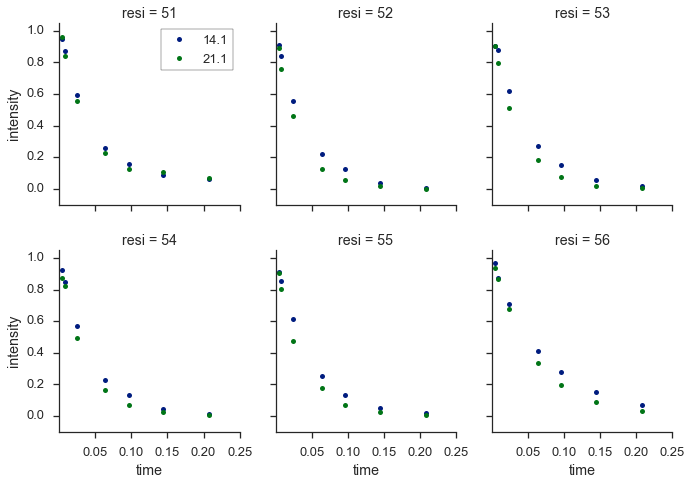

In [33]:
plot_data = fit_data.data.reset_index()
plot_data = plot_data[plot_data.resi>=51]

grid = sns.FacetGrid(plot_data, col='resi', hue='field', #palette=palette,
                     col_wrap=3, size=2.0, aspect=0.75, 
                     sharey=True, despine=True)

# grid.map(plt.plot, 'time', 'ycalc', marker='', ls='-')
grid.map(plt.plot, 'time', 'intensity', marker='o', ms=5, ls='')

grid.set(xticks=np.linspace(0.05, 0.25, 5),
         ylim=(-0.1, 1.05))

grid.axes[0].legend(loc=0, frameon=True)

f = plt.gcf()
f.set_size_inches(12,8)
f.subplots_adjust(wspace=0.2, hspace=0.25)